In [2]:
# 1. Imports
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import re
import optuna

# modeling
from xgboost import XGBRegressor
from xgboost import XGBClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss
from scipy.special import logit, expit
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import TimeSeriesSplit

# PyTorch for conversion model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# nfl pbp loader
import nfl_data_py as nfl

# reproducibility
np.random.seed(42)
torch.manual_seed(42)

In [3]:
# 2a. Download PBP (this can take a few minutes)
seasons = [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2024]
print("Loading play-by-play for seasons:", seasons)
raw_pbp = nfl.import_pbp_data(seasons, downcast=False)  # returns a DataFrame (may be large)

print("Rows loaded:", raw_pbp.shape[0])
raw_pbp.head()

Loading play-by-play for seasons: [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2024]
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2024 done.
Rows loaded: 433940


,play_id,game_id,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,...,was_pressure,route,defense_man_zone_type,defense_coverage_type,offense_names,defense_names,offense_positions,defense_positions,offense_numbers,defense_numbers
0,1.0,2015_01_BAL_DEN,2015091309,DEN,BAL,REG,1,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,36.0,2015_01_BAL_DEN,2015091309,DEN,BAL,REG,1,BAL,away,DEN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,51.0,2015_01_BAL_DEN,2015091309,DEN,BAL,REG,1,BAL,away,DEN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,75.0,2015_01_BAL_DEN,2015091309,DEN,BAL,REG,1,BAL,away,DEN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,96.0,2015_01_BAL_DEN,2015091309,DEN,BAL,REG,1,BAL,away,DEN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
def parse_weather(weather_str):
    """
    Parses a weather string into structured features:
        - temp_F: float
        - humidity: float (percentage)
        - wind_mph: float
        - wind_dir: str
        - conditions: str (general description, e.g., 'sunny', 'cloudy', etc.)
    """
    result = {
        "temp_F": None,
        "humidity": None,
        "wind_mph": None,
        "wind_dir": None,
        "conditions": None
    }
    
    if not isinstance(weather_str, str):
        return result
    
    lower_str = weather_str.lower()
    
    # Extract temperature
    temp_match = re.search(r'(\d+)\s*°?\s*f', lower_str)
    if temp_match:
        result['temp_F'] = float(temp_match.group(1))
    
    # Extract humidity
    hum_match = re.search(r'humidity[:\s]*(\d+)%', lower_str)
    if hum_match:
        result['humidity'] = float(hum_match.group(1))
    
    # Extract wind speed and direction
    wind_match = re.search(r'wind[:\s]*([nesw]+)\s*(\d+)\s*mph', lower_str)
    if wind_match:
        result['wind_dir'] = wind_match.group(1).upper()
        result['wind_mph'] = float(wind_match.group(2))
    
    # Extract general conditions
    conditions = []
    for cond in ['sunny', 'cloudy', 'clear', 'rain', 'snow', 'fog', 'drizzle', 'storm', 'windy']:
        if cond in lower_str:
            conditions.append(cond)
    if conditions:
        result['conditions'] = ','.join(conditions)
    
    return result


def deconstruct_weather(df, weather_col='weather'):
    """
    Adds structured weather columns to a DataFrame based on a weather string column.
    
    New columns added:
      - temp_F
      - humidity
      - wind_mph
      - wind_dir
      - conditions
    """
    weather_data = df[weather_col].apply(parse_weather)
    weather_df = pd.DataFrame(weather_data.tolist())
    df = pd.concat([df.reset_index(drop=True), weather_df], axis=1)
    
    # Fill missing wind speeds with 0
    df['wind_mph'] = df['wind_mph'].fillna(0)

    # Fill missing temperatures with 60°F
    df['temp_F'] = df['temp_F'].fillna(60)

    return df

In [5]:
pbp = raw_pbp.copy()
pbp = deconstruct_weather(pbp)
pbp = pbp[pbp.penalty == 0]

In [6]:
def make_temporal_folds(df, season_col="season", min_train_seasons=3):
    """
    Expanding-window CV folds by season.
    Returns list of (train_idx, val_idx).
    """
    seasons = np.sort(df[season_col].unique())
    folds = []

    for i in range(min_train_seasons, len(seasons)):
        train_seasons = seasons[:i]
        val_season = seasons[i]

        train_idx = df[df[season_col].isin(train_seasons)].index
        val_idx = df[df[season_col] == val_season].index

        folds.append((train_idx, val_idx))

    return folds

In [7]:
# --- Drop rows missing home/away WP ---
wp_df = pbp.dropna(subset=["home_wp_post", "away_wp_post"]).copy()

# --- Define features ---
wp_df["score_time_ratio"] = wp_df["score_differential"].abs() / (wp_df["game_seconds_remaining"] + 1)
wp_features = [
    "yardline_100",
    "down",
    "ydstogo",
    "game_seconds_remaining",
    "half_seconds_remaining",
    "score_differential",
    "posteam_timeouts_remaining",
    "defteam_timeouts_remaining",
    "score_time_ratio",
    "temp_F",
    "wind_mph"
]

# --- Define posteam WP target ---
wp_df["wp_target"] = np.where(
    wp_df["posteam"] == wp_df["home_team"],
    wp_df["home_wp_post"],
    wp_df["away_wp_post"]
)

wp_df = wp_df.reset_index(drop=True)

X_wp = wp_df[wp_features]
y_wp = wp_df["wp_target"]

# --- Clip target to avoid exact 0/1 ---
epsilon = 1e-6
y_wp_clipped = y_wp.clip(epsilon, 1 - epsilon).reset_index(drop=True)

# --- Monotone constraints (time variables unconstrained now) ---
monotone_constraints_dict = {
    "yardline_100": -1,               # closer to opponent endzone → WP ↑
    "down": -1,                       # higher down (worse) → WP ↓
    "ydstogo": -1,                    # more yards to go → WP ↓
    "score_differential": 1,          # lead → WP ↑
    "posteam_timeouts_remaining": 1,  # more TOs → WP ↑
    "defteam_timeouts_remaining": -1  # opponent TOs → WP ↓
}

wp_folds = make_temporal_folds(wp_df)

In [8]:
def wp_objective(trial):

    params = {
        "max_depth": trial.suggest_int("max_depth", 3, 5),
        "learning_rate": trial.suggest_float("learning_rate", 0.02, 0.08),
        "n_estimators": trial.suggest_int("n_estimators", 200, 400),
        "subsample": trial.suggest_float("subsample", 0.7, 0.9),
        "min_child_weight": trial.suggest_int("min_child_weight", 20, 100),
        "verbosity": 0,
        "monotone_constraints": monotone_constraints_dict,
    }

    rmses = []

    for train_idx, val_idx in wp_folds:
        X_train, X_val = X_wp.iloc[train_idx], X_wp.iloc[val_idx]
        y_train, y_val = y_wp_clipped.iloc[train_idx], y_wp_clipped.iloc[val_idx]

        model = XGBRegressor(**params)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_val, y_val)],
            eval_metric="rmse",
            early_stopping_rounds=10,
            verbose=False
        )

        preds = model.predict(X_val)
        rmse = mean_squared_error(y_val, preds, squared=False)
        rmses.append(rmse)

    return np.mean(rmses)

In [9]:
wp_study = optuna.create_study(direction="minimize")
wp_study.optimize(wp_objective, n_trials=3)

[I 2025-12-27 08:15:20,692] A new study created in memory with name: no-name-8a3ff9ba-0e8d-4284-994f-ae9c3aa04cd8
C:\Users\david\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\david\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\david\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\david\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for be

C:\Users\david\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\david\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\david\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\david\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warning

In [10]:
best_params = wp_study.best_params
best_score = wp_study.best_value

print("Best CV RMSE:", best_score)
print("Best params:", best_params)

Best CV RMSE: 0.059402182696192816
Best params: {'max_depth': 5, 'learning_rate': 0.07954346105967944, 'n_estimators': 361, 'subsample': 0.8019018241263233, 'min_child_weight': 81}


In [11]:
# Add monotone constraints if not in params already
best_params["monotone_constraints"] = monotone_constraints_dict
best_params["verbosity"] = 0

wp_model = XGBRegressor(**best_params)
wp_model.fit(X_wp, y_wp_clipped)  # Train on full dataset


def predict_wp(state_df):
    if "score_time_ratio" not in state_df:
        state_df["score_time_ratio"] = state_df["score_differential"].abs() / (state_df["game_seconds_remaining"] + 1)
    preds = wp_model.predict(state_df[wp_features])
    return np.clip(preds, 0.0, 1.0)

In [12]:
def flip_possession(state):
    """
    Flip possession for WP prediction.
    Returns a new state dict from the perspective of the new posteam.
    """
    new_state = state.copy()
    # Negate score differential
    new_state["score_differential"] = -state["score_differential"]
    # Swap timeouts
    new_state["posteam_timeouts_remaining"] = state["defteam_timeouts_remaining"]
    new_state["defteam_timeouts_remaining"] = state["posteam_timeouts_remaining"]
    
    return new_state

In [13]:
# Create punt_df with only punt plays
punt_df = pbp[pbp.play_type == "punt"].dropna(subset=["kick_distance", "return_yards"]).copy()

# Compute net punt yardage: kick distance minus return yards, adjust for touchbacks (if available)
# Assuming touchback puts ball at 20-yard line
punt_df["net_punt"] = punt_df["kick_distance"] - punt_df["return_yards"]
punt_df.loc[punt_df["touchback"] == 1, "net_punt"] = punt_df["yardline_100"] - 20

# Reset index to avoid any issues
punt_df = punt_df.reset_index(drop=True)

# Make temporal folds based on seasons in punt_df
punt_folds = make_temporal_folds(punt_df, season_col="season", min_train_seasons=3)

# Features to predict net punt
punt_features = [
    "yardline_100", 
    "game_seconds_remaining", 
    "half_seconds_remaining",
    "score_differential",
    "posteam_timeouts_remaining",
    "defteam_timeouts_remaining",
    "temp_F",
    "wind_mph"
]

X_punt = punt_df[punt_features].values
y_punt = punt_df["net_punt"].values

X_scaler = StandardScaler()
X_punt_scaled = X_scaler.fit_transform(X_punt)

y_scaler = StandardScaler()
y_punt_scaled = y_scaler.fit_transform(y_punt.reshape(-1,1))

In [14]:
def punt_objective(trial):
    # Suggest hyperparameters
    n_layers = trial.suggest_int("n_layers", 1, 3)
    hidden_size = trial.suggest_int("hidden_size", 16, 128)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    dropout_rate = trial.suggest_float("dropout", 0.0, 0.5)
    epochs = 50  # you can tune this later

    rmses = []

    # Loop over temporal folds
    for train_idx, val_idx in punt_folds:
        # Prepare fold data
        X_train = torch.tensor(X_punt_scaled[train_idx], dtype=torch.float32)
        y_train = torch.tensor(y_punt_scaled[train_idx], dtype=torch.float32)
        X_val = torch.tensor(X_punt_scaled[val_idx], dtype=torch.float32)
        y_val = torch.tensor(y_punt_scaled[val_idx], dtype=torch.float32)

        input_dim = X_train.shape[1]

        # Build the network
        layers = []
        for i in range(n_layers):
            layers.append(nn.Linear(input_dim if i == 0 else hidden_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
        layers.append(nn.Linear(hidden_size, 1))
        # For regression, remove Sigmoid. Keep raw output
        model = nn.Sequential(*layers)

        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        # Training loop
        model.train()
        for epoch in range(epochs):
            optimizer.zero_grad()
            outputs = model(X_train)
            loss = criterion(outputs, y_train)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            val_preds = model(X_val)
            val_loss = criterion(val_preds, y_val).item()
            rmses.append(np.sqrt(val_loss))  # RMSE for consistency

    # Return mean RMSE across folds
    return np.mean(rmses)

In [15]:
punt_study = optuna.create_study(direction="minimize")
punt_study.optimize(punt_objective, n_trials=3)

[I 2025-12-27 08:20:18,824] A new study created in memory with name: no-name-69d42eb2-5d9a-4dea-ae09-6f3bc2bf3d73
[I 2025-12-27 08:20:32,189] Trial 0 finished with value: 0.9442755354659632 and parameters: {'n_layers': 2, 'hidden_size': 62, 'lr': 0.00038509397474618305, 'dropout': 0.3439172308844486}. Best is trial 0 with value: 0.9442755354659632.
[I 2025-12-27 08:20:53,621] Trial 1 finished with value: 0.9166722288083106 and parameters: {'n_layers': 3, 'hidden_size': 76, 'lr': 0.0071255451897258215, 'dropout': 0.38824066470374413}. Best is trial 1 with value: 0.9166722288083106.
[I 2025-12-27 08:21:05,405] Trial 2 finished with value: 0.918437090113441 and parameters: {'n_layers': 2, 'hidden_size': 49, 'lr': 0.004092443134288515, 'dropout': 0.4946121010785532}. Best is trial 1 with value: 0.9166722288083106.


In [16]:
best_params = punt_study.best_params
best_score = punt_study.best_value
n_layers = best_params["n_layers"]
hidden_size = best_params["hidden_size"]
dropout_rate = best_params["dropout"]
lr = best_params["lr"]

print("Best CV RMSE:", best_score)
print("Best params:", best_params)

Best CV RMSE: 0.9166722288083106
Best params: {'n_layers': 3, 'hidden_size': 76, 'lr': 0.0071255451897258215, 'dropout': 0.38824066470374413}


In [17]:
# Build final model
layers = []
input_dim = X_punt_scaled.shape[1]
for i in range(n_layers):
    layers.append(nn.Linear(input_dim if i==0 else hidden_size, hidden_size))
    layers.append(nn.ReLU())
    layers.append(nn.Dropout(dropout_rate))
layers.append(nn.Linear(hidden_size, 1))
punt_model = nn.Sequential(*layers)

# Convert full data to tensors
X_t = torch.tensor(X_punt_scaled, dtype=torch.float32)
y_t = torch.tensor(y_punt_scaled, dtype=torch.float32)

optimizer = torch.optim.Adam(punt_model.parameters(), lr=lr)
loss_fn = nn.MSELoss()

# Train final model
epochs = 1000  # or tune
for epoch in range(epochs):
    optimizer.zero_grad()
    preds = punt_model(X_t)
    loss = loss_fn(preds, y_t)
    loss.backward()
    optimizer.step()

In [88]:
def predict_punt(state_dict):
    """
    state_dict can be a DataFrame (multiple rows) or a Series (single row)
    """
    # Ensure 2D input
    if isinstance(state_dict, pd.Series):
        state_df = pd.DataFrame([state_dict])
    else:
        state_df = state_dict

    x_scaled = X_scaler.transform(state_df[punt_features])
    x_t = torch.tensor(x_scaled, dtype=torch.float32)

    with torch.no_grad():
        y_scaled_pred = punt_model(x_t).numpy().ravel()  # works for batch or single row

    net_punt = y_scaler.inverse_transform(y_scaled_pred.reshape(-1, 1)).ravel()

    # Return scalar if single row, else array
    if len(net_punt) == 1:
        return net_punt[0]
    return net_punt

In [19]:
def evaluate_punt(state):
    """
    Evaluate a punt attempt.
    Returns expected WP for the punting team after the punt.
    """
    df = pd.DataFrame([state])
    wp_current = predict_wp(df)[0] 

    # Predict net punt
    net_punt = predict_punt(df[punt_features])

    # Compute receiving team's field position
    if net_punt >= state["yardline_100"]:
        new_yardline_100 = 80  # Touchback → opponent at own 20
    else:
        new_yardline_100 = 100 - (state["yardline_100"] - net_punt)

    # Construct post-punt state for opponent
    punt_result_state = state.copy()
    punt_result_state["yardline_100"] = new_yardline_100
    punt_result_state["down"] = 1
    punt_result_state["ydstogo"] = 10

    # Flip possession
    punt_result_state_flipped = flip_possession(punt_result_state)
    punt_result_state_flipped['half_seconds_remaining'] = max(0, punt_result_state_flipped['half_seconds_remaining'] - 8)
    punt_result_state_flipped['game_seconds_remaining'] = max(0, punt_result_state_flipped['game_seconds_remaining'] - 8)

    # Opponent WP
    wp_opponent = predict_wp(pd.DataFrame([punt_result_state_flipped]))[0]

    # Punting team's expected WP
    ewp_punt = 1 - wp_opponent
    
    # Account for late-game scenario
    if state['score_differential'] <= -1:
        # Assume each timeout saves 42 seconds
        if state['game_seconds_remaining'] <= 42 * (3 - state['posteam_timeouts_remaining']):
                ewp_punt = 0

    return {
        "wp_current": round(wp_current, 4),
        "net_punt": round(net_punt, 4),
        "ewp_punt": round(ewp_punt, 4)
    }

In [53]:
# --- Filter to field goal attempts only ---
fg_df = pbp[pbp.play_type == "field_goal"].dropna(subset=["field_goal_result"]).copy()
fg_df = fg_df[fg_df.field_goal_result.isin(['made', 'missed', 'blocked'])]
fg_df = fg_df[fg_df.kick_distance >= 17]

# --- Map result to 1/0 ---
fg_df["fg_made"] = (fg_df["field_goal_result"] == "made").astype(int)

# Field goal
fg_df["score_time_ratio"] = fg_df["score_differential"].abs() / (fg_df["game_seconds_remaining"] + 1)
fg_features = [
    "kick_distance",
    "game_seconds_remaining",
    "half_seconds_remaining",
    "score_differential",
    "score_time_ratio",
    "temp_F",
    "wind_mph"
]

X_fg = fg_df[fg_features]
y_fg = fg_df["fg_made"]

fg_folds = make_temporal_folds(
    fg_df,
    season_col="season",
    min_train_seasons=3
)

fg_oof_pred = pd.Series(index=fg_df.index, dtype=float)
fg_df["fg_make_prob_oof"] = fg_oof_pred

for fold_num, (train_idx, val_idx) in enumerate(fg_folds, 1):
    X_train = X_fg.loc[train_idx]
    y_train = y_fg.loc[train_idx]
    X_val   = X_fg.loc[val_idx]

    fg_model_lr_fold = LogisticRegression(
        solver="lbfgs",
        max_iter=1000
    )

    fg_model_lr_fold.fit(X_train, y_train)

    fg_oof_pred.loc[val_idx] = fg_model_lr_fold.predict_proba(X_val)[:, 1]

fg_oof_rmse = np.sqrt(
    np.mean((fg_oof_pred.values - y_fg.values) ** 2)
)

mask = fg_oof_pred.notna()
fg_oof_rmse = np.sqrt(np.mean((fg_oof_pred[mask] - y_fg[mask]) ** 2))
print("FG (LogReg) OOF RMSE:", fg_oof_rmse)

fg_final_model = LogisticRegression(
    solver="lbfgs",
    max_iter=1000
)

fg_final_model.fit(X_fg, y_fg)

FG fold 1: trained on seasons 2015–2017, validated on 2018
FG fold 2: trained on seasons 2015–2018, validated on 2019
FG fold 3: trained on seasons 2015–2019, validated on 2020
FG fold 4: trained on seasons 2015–2020, validated on 2021
FG fold 5: trained on seasons 2015–2021, validated on 2022
FG fold 6: trained on seasons 2015–2022, validated on 2024
FG (LogReg) OOF RMSE: 0.3409692365802886


LogisticRegression(max_iter=1000)

In [54]:
def predict_fg(state_dict):
    df = pd.DataFrame([state_dict])

    if "score_time_ratio" not in df:
        df["score_time_ratio"] = (
            df["score_differential"].abs()
            / (df["game_seconds_remaining"] + 1)
        )

    p_make = fg_final_model.predict_proba(df[fg_features])[:, 1][0]

    # Long-kick decay
    decay_threshold = 55
    kick_distance = state_dict["kick_distance"]

    if kick_distance >= decay_threshold:
        p_make *= max(
            0,
            (70 - kick_distance) / (70 - decay_threshold)
        )

    return np.clip(p_make, 0.0, 1.0)

In [55]:
def evaluate_field_goal(state):
    """Evaluates a field goal attempt."""
    df = pd.DataFrame([state])
    wp_current = predict_wp(df)[0]
    
    fg_state = state.copy()
    fg_state['kick_distance'] = fg_state['yardline_100'] + 17

    # Predict FG make probability
    p_make = predict_fg(fg_state)

    # State after successful FG
    fg_success_state = state.copy()
    fg_success_state["down"] = 1
    fg_success_state["ydstogo"] = 10
    fg_success_state['yardline_100'] = 75
    fg_success_state["score_differential"] += 3
    fg_success_state = flip_possession(fg_success_state)
    fg_success_state['half_seconds_remaining'] = max(0, fg_success_state['half_seconds_remaining'] - 5)
    fg_success_state['game_seconds_remaining'] = max(0, fg_success_state['game_seconds_remaining'] - 5)
    wp_success = 1 - predict_wp(pd.DataFrame([fg_success_state]))[0]

    # State after missed FG (opponent gets ball)
    fg_fail_state = state.copy()
    fg_fail_state["down"] = 1
    fg_fail_state["ydstogo"] = 10
    fg_fail_state["yardline_100"] = 100 - (state["yardline_100"] + 7)
    fg_fail_state = flip_possession(fg_fail_state)
    fg_fail_state['half_seconds_remaining'] = max(0, fg_fail_state['half_seconds_remaining'] - 5)
    fg_fail_state['game_seconds_remaining'] = max(0, fg_fail_state['game_seconds_remaining'] - 5)
    wp_fail_for_us = 1 - predict_wp(pd.DataFrame([fg_fail_state]))[0]
    
    # Account for late-game scenario
    if state['score_differential'] <= -4:
        # Assume each timeout saves 42 seconds
        if state['game_seconds_remaining'] <= 42 * (3 - state['posteam_timeouts_remaining']):
                wp_success = 0
                wp_fail_for_us = 0
    
    # Expected WP
    ewp_field_goal = p_make * wp_success + (1 - p_make) * wp_fail_for_us

    return {
        "wp_current": round(wp_current,4),
        "p_make": round(p_make,4),
        "wp_success": round(wp_success,4),
        "wp_fail": round(wp_fail_for_us,4),
        "ewp_field_goal": round(ewp_field_goal,4)
    }

In [56]:
# Filter to 4th-down go-for-it plays
go_df = pbp[
    (pbp['down'] == 4) &
    (pbp['play_type'].isin(['run', 'pass']))  # filters out punts/FGs
].copy()

# Target: did the team convert?
go_df = go_df.dropna(subset=['first_down'])

# Go-for-it conversion
go_df["score_time_ratio"] = go_df["score_differential"].abs() / (go_df["game_seconds_remaining"] + 1)

go_df["success"] = (
    (go_df["first_down"] == 1) |
    (go_df["touchdown"] == 1)
).astype(int)

# Reset index to avoid any issues
go_df = go_df.reset_index(drop=True)

# Make temporal folds based on seasons in punt_df
go_folds = make_temporal_folds(go_df, season_col="season", min_train_seasons=3)

# Features to predict net punt
go_features = [
    "yardline_100",
    "ydstogo",
    "game_seconds_remaining",
    "half_seconds_remaining",
    "score_differential",
    "posteam_timeouts_remaining",
    "defteam_timeouts_remaining",
    "score_time_ratio",
    "temp_F",
    "wind_mph"
]

X_go = go_df[go_features].values
y_go = go_df["success"].values

In [23]:
monotone_constraints = [
    -1,  # yardline_100 (farther → worse)
    -1,  # ydstogo (longer → worse)
    0,   # game_seconds_remaining
    0,   # half_seconds_remaining
    1,   # score_differential
    0,   # posteam_timeouts_remaining
    0,   # defteam_timeouts_remaining
    -1,  # score_time_ratio
    0,   # temp_F
    0    # wind_mph
]


def go_objective(trial):
    # Suggest hyperparameters
    params = {
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "objective": "binary:logistic",
        "monotone_constraints": tuple(monotone_constraints),
        "eval_metric": "logloss",
        "use_label_encoder": False
    }

    log_losses = []

    # Use your temporal folds if available
    for train_idx, val_idx in go_folds:  # or go_for_it_folds
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_go[train_idx])
        X_val = scaler.transform(X_go[val_idx])
        y_train, y_val = y_go[train_idx], y_go[val_idx]

        model = XGBClassifier(**params)
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            verbose=False
        )
        preds = model.predict_proba(X_val)[:, 1]
        log_losses.append(log_loss(y_val, preds))

    return np.mean(log_losses)

In [24]:
go_study = optuna.create_study(direction="minimize")
go_study.optimize(go_objective, n_trials=3)

[I 2025-12-27 08:22:47,977] A new study created in memory with name: no-name-42f27de7-aea2-429e-ab7e-2df2f867458a
[I 2025-12-27 08:23:14,599] Trial 0 finished with value: 0.6515838673927798 and parameters: {'max_depth': 3, 'learning_rate': 0.014372876512617221, 'n_estimators': 169, 'subsample': 0.7697473636278307, 'colsample_bytree': 0.9465740209622754}. Best is trial 0 with value: 0.6515838673927798.
[I 2025-12-27 08:24:58,965] Trial 1 finished with value: 0.6738825279340429 and parameters: {'max_depth': 5, 'learning_rate': 0.0010093619418597728, 'n_estimators': 425, 'subsample': 0.6545874751506737, 'colsample_bytree': 0.5215227779918301}. Best is trial 0 with value: 0.6515838673927798.
[I 2025-12-27 08:25:31,938] Trial 2 finished with value: 0.6767256934929423 and parameters: {'max_depth': 4, 'learning_rate': 0.0021340777919944113, 'n_estimators': 169, 'subsample': 0.75028216803424, 'colsample_bytree': 0.5113838348149282}. Best is trial 0 with value: 0.6515838673927798.


In [25]:
# Scale features
scaler = StandardScaler()
X_go_scaled = scaler.fit_transform(X_go)

# Add monotone constraints & other fixed params
best_score = go_study.best_value
best_params = go_study.best_trial.params
best_params["monotone_constraints"] = tuple(monotone_constraints)
best_params["use_label_encoder"] = False
best_params["eval_metric"] = "logloss"
print("Best params:", best_params)

# Train final conversion model
conv_model = XGBClassifier(**best_params)
conv_model.fit(X_go_scaled, y_go)

Best params: {'max_depth': 3, 'learning_rate': 0.014372876512617221, 'n_estimators': 169, 'subsample': 0.7697473636278307, 'colsample_bytree': 0.9465740209622754, 'monotone_constraints': (-1, -1, 0, 0, 1, 0, 0, -1, 0, 0), 'use_label_encoder': False, 'eval_metric': 'logloss'}


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9465740209622754, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.014372876512617221,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan,
              monotone_constraints=(-1, -1, 0, 0, 1, 0, 0, -1, 0, 0),
              multi_strategy=None, n_estimators=169, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [94]:
def go_for_it_success_penalty(ydstogo, wp_current, game_seconds_remaining, alpha=0.035, c=3.5):
    """
    Penalty applied to wp_success for go-for-it attempts.
    Returns a non-negative WP penalty.
    """

    # --- Distance penalty (accelerating beyond 2 yards)
    dist_term = np.exp((ydstogo - 2) / c) - 1
    dist_term = np.maximum(0.0, dist_term)

    # --- WP weighting: strongest near wp_current = 0.5
    wp_weight = 1.0 - 4.0 * (wp_current - 0.5) ** 2
    wp_weight = np.clip(wp_weight, 0.0, 1.0)

    # --- Time weighting: fades late in game
    time_weight = np.minimum(1.0, game_seconds_remaining / 900.0)

    penalty = alpha * dist_term * wp_weight * time_weight

    return penalty

In [170]:
def scoring_possessions_to_tie(score_differential):
    
    if score_differential >= 0:
        return 0
    abs_diff = abs(score_differential)
    
    return min(
        np.ceil(abs_diff / 8),   # TD + 2PT possessions
        np.ceil(abs_diff / 7),   # TD possessions
        np.ceil(abs_diff / 3)    # FG possessions
    )


def possessions_to_tie_boost(possessions_to_tie):
    
    if possessions_to_tie == 0:
        return 0
    else:
        return 0.03 * np.exp(1 - possessions_to_tie)

In [159]:
def evaluate_go_for_it(state):
    """Evaluates a 4th down go-for-it attempt."""
    df = pd.DataFrame([state])
    wp_current = predict_wp(df)[0]

    p_conv = conv_model.predict_proba(df[go_features])[:, 1][0]

    # WP if conversion succeeds
    go_success_state = state.copy()
    go_success_state["down"] = 1
    go_success_state["yardline_100"] = np.maximum(1, state["yardline_100"] - state['ydstogo'])
    go_success_state['ydstogo'] = np.minimum(10, go_success_state['yardline_100']) # Account for 1st & goal
    go_success_state['half_seconds_remaining'] = np.maximum(0, go_success_state['half_seconds_remaining'] - 5) # Assume play lenght is 5 seconds
    go_success_state['game_seconds_remaining'] = np.maximum(0, go_success_state['game_seconds_remaining'] - 5)
    wp_success = predict_wp(pd.DataFrame([go_success_state]))[0]
    
    penalty = go_for_it_success_penalty(
        ydstogo=state["ydstogo"],
        wp_current=wp_current,
        game_seconds_remaining=state["game_seconds_remaining"],
        alpha=0.035,
        c=3.5)
    
    # WP if conversion fails
    go_fail_state = state.copy()
    go_fail_state["down"] = 1
    go_fail_state["ydstogo"] = 10
    go_fail_state["yardline_100"] = 100 - state["yardline_100"]
    go_fail_state = flip_possession(go_fail_state)
    go_fail_state['half_seconds_remaining'] = np.maximum(0, go_fail_state['half_seconds_remaining'] - 5)
    go_fail_state['game_seconds_remaining'] = np.maximum(0, go_fail_state['game_seconds_remaining'] - 5)
    wp_fail_for_us = 1 - predict_wp(pd.DataFrame([go_fail_state]))[0]
    
    # Conditional success adjustment
    possessions_to_tie = scoring_possessions_to_tie(state['score_differential'])
    discrete_possessions_boost = possessions_to_tie_boost(possessions_to_tie)
    
    # Expected WP
    ewp_go_for_it = p_conv * (wp_success + discrete_possessions_boost) + (1 - p_conv) * wp_fail_for_us
    
    ewp_go_for_it_adj = np.clip(ewp_go_for_it - penalty, 0, 1)
    
    return {
        "wp_current": round(wp_current,4),
        "p_conv": round(p_conv,4),
        "wp_success": round(wp_success,4),
        "wp_fail": round(wp_fail_for_us,4),
        "ewp_go_for_it": round(ewp_go_for_it,4),
        "ewp_go_for_it_adj": round(ewp_go_for_it_adj,4)
    }

In [29]:
def sigmoid(x):
    
    return 1 / (1 + np.exp(-x))

In [30]:
def required_margin_multiplier(yardline, score_differential, game_seconds_remaining):
    """
    Penalizes aggression as the team has a bigger lead, more time, or is deeper in their own territory.
    Returns a weight that multiplies raw aggression.
    """

    # --- Smooth score/time-based weight
    score_time_ratio = np.clip(score_differential / (game_seconds_remaining + 1), -1, 1)
    ratio_weight = sigmoid(3 * score_time_ratio) # ratio_weight ~ 0 when trailing, ~1 when leading
    
    # --- Yardline weight (higher in opponent territory → more aggressive, lower in own territory → less aggressive)
    yardline_weight = 0.5 + 0.5 * sigmoid(0.1 * yardline - 5)

    # --- Final aggression adjustment
    return (ratio_weight + 0.05 * score_differential) * yardline_weight

In [31]:
def evaluate_play_options(state):
    """Evaluates all 3 options on a 4th down."""
    # WP from current state
    wp_current = predict_wp(pd.DataFrame([state]))[0]

    # Evaluate each option
    punt_result = evaluate_punt(state)
    fg_result = evaluate_field_goal(state)
    go_result = evaluate_go_for_it(state)
    
    # Compute raw EWPs
    ewp_punt = punt_result["ewp_punt"]
    ewp_field_goal = fg_result["ewp_field_goal"]
    ewp_go_raw = go_result["ewp_go_for_it"]
    ewp_go_adj = go_result["ewp_go_for_it_adj"]
    
    # Compute WPAs
    wpa_punt = ewp_punt - wp_current
    wpa_field_goal = ewp_field_goal - wp_current
    wpa_go_for_it = ewp_go_adj - wp_current
    
    # Best conservative option
    best_conservative = max(ewp_punt, ewp_field_goal)

    # Raw go-for-it edge
    aggression_edge = ewp_go_adj - best_conservative

    # Contextual margin requirement
    strength = 0.03  # smaller now — acts as a threshold, not a tax
    required_margin = strength * required_margin_multiplier(
        state["yardline_100"],
        state["score_differential"],
        state["game_seconds_remaining"]
    )

    # Decision gating (NO EWP distortion)
    if aggression_edge > required_margin:
        recommended_play = "go_for_it"
    else:
        recommended_play = (
            "punt" if ewp_punt >= ewp_field_goal else "field_goal"
        )

    # Consolidate results
    results = {
        "wp_current": round(wp_current, 4),
        "ewp_punt": round(ewp_punt, 4),
        "ewp_field_goal": round(ewp_field_goal, 4),
        "ewp_go_raw": round(ewp_go_raw, 4),
        "ewp_go_adj": round(ewp_go_adj, 4),
        "required_margin": round(required_margin, 4),
        "wpa_punt": round(wpa_punt, 4),
        "wpa_field_goal": round(wpa_field_goal, 4),
        "wpa_go_for_it": round(wpa_go_for_it, 4),
        "recommended_play": recommended_play
    }

    return results

In [160]:
state = {
    "yardline_100": 31,             
    "down": 4,
    "ydstogo": 2,                   
    "game_seconds_remaining": 140,   
    "half_seconds_remaining": 140,
    "score_differential": 0,       
    "posteam_timeouts_remaining": 3,
    "defteam_timeouts_remaining": 1,
    "temp_F" : 60,
    "wind_mph" : 0
}

evaluate_play_options(state)

{'wp_current': 0.6428,
 'ewp_punt': 0.5985,
 'ewp_field_goal': 0.6163,
 'ewp_go_raw': 0.5602,
 'ewp_go_adj': 0.5602,
 'required_margin': 0.0085,
 'wpa_punt': -0.0443,
 'wpa_field_goal': -0.0265,
 'wpa_go_for_it': -0.0826,
 'recommended_play': 'field_goal'}

In [96]:
evaluate_punt(state)

{'wp_current': 0.6428, 'net_punt': 20.5494, 'ewp_punt': 0.5688}

In [97]:
evaluate_field_goal(state)

{'wp_current': 0.6428,
 'p_make': 0.7548,
 'wp_success': 0.6674,
 'wp_fail': 0.4589,
 'ewp_field_goal': 0.6163}

In [98]:
evaluate_go_for_it(state)

{'wp_current': 0.6428,
 'p_conv': 0.2728,
 'wp_success': 0.7554,
 'wp_fail': 0.4869,
 'ewp_go_for_it': 0.5602,
 'ewp_go_for_it_adj': 0.5602}

In [61]:
action_order = {
    "go_for_it": 2,
    "field_goal": 1,
    "punt": 0
}

def sweep_state(
    base_state,
    sweep_var,
    sweep_values,
    evaluate_fn=evaluate_play_options
):
    """
    Sweeps one variable while holding others fixed.
    Returns a list of dicts with state, EWPs, and decision.
    """
    results = []

    for v in sweep_values:
        state = base_state.copy()
        state[sweep_var] = v

        out = evaluate_fn(state)

        results.append({
            sweep_var: v,
            "recommended_play": out["recommended_play"],
            "action_score": action_order[out["recommended_play"]],
            "ewp_punt": out["ewp_punt"],
            "ewp_field_goal": out["ewp_field_goal"],
            "ewp_go_for_it": out["ewp_go_adj"],
        })

    return pd.DataFrame(results)


def detect_monotonicity_violations(df, aggression_is_decreasing):
    """
    Detects non-monotonic reversals in action_score and
    records the delta in EWP of the recommended play across the violation.
    """
    scores = df["action_score"].values

    violations = []
    delta_ewps = []

    for i in range(1, len(scores)):
        violation = False

        if aggression_is_decreasing:
            violation = scores[i] > scores[i - 1]
        else:
            violation = scores[i] < scores[i - 1]

        if violation:
            violations.append((i - 1, i))

            # Identify recommended play for each row
            recommended_prev = df.loc[i - 1, "recommended_play"]
            recommended_curr = df.loc[i, "recommended_play"]

            ewp_prev = df.loc[i - 1, f"ewp_{recommended_prev}"]
            ewp_curr = df.loc[i, f"ewp_{recommended_curr}"]

            delta_ewps.append(abs(ewp_curr - ewp_prev))

    return violations, delta_ewps


def describe_violations(df, violations, sweep_var):
    for i, j in violations:
        row_i = df.iloc[i]
        row_j = df.iloc[j]
        print(
            f"{sweep_var}: {row_i[sweep_var]} → {row_j[sweep_var]} | "
            f"{row_i['recommended_play']} → {row_j['recommended_play']}"
        )
        
        
def detect_monotonicity_behavior(base_state, sweep_var, sweep_range, aggression_is_decreasing):
    
    df = sweep_state(base_state, sweep_var, sweep_range)
    violations, delta_ewps = detect_monotonicity_violations(df, aggression_is_decreasing)
    describe_violations(df, violations, sweep_var)
    
    return df, violations, delta_ewps

In [62]:
monotonic_tests = [
    # As score_differential gets more positive, aggression should decrease
    ("score_differential", range(-14, 15), True),

    # As yards to go increases, aggression should decrease
    ("ydstogo", range(1, 11), True),

    # As yardline_100 increases (team is deeper in their own territory), aggression should decrease
    ("yardline_100", range(10, 90), True)
]

base_states = [
    # Early game, neutral score
    {"yardline_100": 30, "down": 4, "ydstogo": 3, "game_seconds_remaining": 1800, "half_seconds_remaining": 1800, "score_differential": 0, "posteam_timeouts_remaining": 3, "defteam_timeouts_remaining": 3, "temp_F": 60, "wind_mph": 0},

    # Late game, trailing
    {"yardline_100": 40, "down": 4, "ydstogo": 2, "game_seconds_remaining": 120, "half_seconds_remaining": 120, "score_differential": -7, "posteam_timeouts_remaining": 1, "defteam_timeouts_remaining": 2, "temp_F": 70, "wind_mph": 5},

    # Late game, leading
    {"yardline_100": 25, "down": 4, "ydstogo": 1, "game_seconds_remaining": 180, "half_seconds_remaining": 180, "score_differential": 10, "posteam_timeouts_remaining": 2, "defteam_timeouts_remaining": 1, "temp_F": 65, "wind_mph": 0},

    # Goal-to-go, short distance
    {"yardline_100": 5, "down": 4, "ydstogo": 1, "game_seconds_remaining": 600, "half_seconds_remaining": 600, "score_differential": 0, "posteam_timeouts_remaining": 3, "defteam_timeouts_remaining": 3, "temp_F": 55, "wind_mph": 0},

    # Goal-to-go, longer distance
    {"yardline_100": 3, "down": 4, "ydstogo": 4, "game_seconds_remaining": 900, "half_seconds_remaining": 900, "score_differential": -3, "posteam_timeouts_remaining": 2, "defteam_timeouts_remaining": 2, "temp_F": 60, "wind_mph": 0},

    # Midfield, short distance
    {"yardline_100": 50, "down": 4, "ydstogo": 1, "game_seconds_remaining": 900, "half_seconds_remaining": 900, "score_differential": 0, "posteam_timeouts_remaining": 3, "defteam_timeouts_remaining": 3, "temp_F": 60, "wind_mph": 0},

    # Midfield, long distance
    {"yardline_100": 50, "down": 4, "ydstogo": 8, "game_seconds_remaining": 1200, "half_seconds_remaining": 1200, "score_differential": -3, "posteam_timeouts_remaining": 2, "defteam_timeouts_remaining": 2, "temp_F": 60, "wind_mph": 0},

    # Own 40 yardline, moderate distance
    {"yardline_100": 60, "down": 4, "ydstogo": 5, "game_seconds_remaining": 1500, "half_seconds_remaining": 1500, "score_differential": 3, "posteam_timeouts_remaining": 3, "defteam_timeouts_remaining": 3, "temp_F": 65, "wind_mph": 0},

    # Opponent 40 yardline, moderate distance
    {"yardline_100": 40, "down": 4, "ydstogo": 5, "game_seconds_remaining": 1500, "half_seconds_remaining": 1500, "score_differential": -3, "posteam_timeouts_remaining": 3, "defteam_timeouts_remaining": 3, "temp_F": 65, "wind_mph": 0},

    # Neutral field, long distance, early game
    {"yardline_100": 50, "down": 4, "ydstogo": 10, "game_seconds_remaining": 1800, "half_seconds_remaining": 1800, "score_differential": 0, "posteam_timeouts_remaining": 3, "defteam_timeouts_remaining": 3, "temp_F": 60, "wind_mph": 0},

    # Own red zone, trailing
    {"yardline_100": 10, "down": 4, "ydstogo": 2, "game_seconds_remaining": 300, "half_seconds_remaining": 300, "score_differential": -4, "posteam_timeouts_remaining": 2, "defteam_timeouts_remaining": 3, "temp_F": 55, "wind_mph": 0},

    # Opponent red zone, leading
    {"yardline_100": 90, "down": 4, "ydstogo": 2, "game_seconds_remaining": 300, "half_seconds_remaining": 300, "score_differential": 7, "posteam_timeouts_remaining": 2, "defteam_timeouts_remaining": 3, "temp_F": 55, "wind_mph": 0},
]


In [63]:
def organize_monotonic_violations(base_states, monotonic_tests):
    
    monotonic_diagnostics = {}

    for state_idx, base_state in enumerate(base_states):

        print()
        print("--------------------------------------------------------")
        print(json.dumps(base_state, indent=4))
        print()

        state_diagnostics = {
            "base_state": base_state,
            "sweep_results": {}
        }

        for sweep_var, sweep_range, aggression_is_decreasing in monotonic_tests:

            df, violations, delta_ewps = detect_monotonicity_behavior(
                base_state,
                sweep_var=sweep_var,
                sweep_range=sweep_range,
                aggression_is_decreasing=aggression_is_decreasing
            )

            violation_records = []

            for (i, j), delta in zip(violations, delta_ewps):
                row_i = df.iloc[i]
                row_j = df.iloc[j]

                violation_records.append({
                    "from_value": row_i[sweep_var],
                    "to_value": row_j[sweep_var],
                    "from_action": row_i["recommended_play"],
                    "to_action": row_j["recommended_play"],
                    "delta_ewp": delta
                })

            state_diagnostics["sweep_results"][sweep_var] = {
                "aggression_is_decreasing": aggression_is_decreasing,
                "violations": violation_records
            }

        monotonic_diagnostics[state_idx] = state_diagnostics
        
    return monotonic_diagnostics

In [64]:
monotonic_diagnostics = organize_monotonic_violations(base_states, monotonic_tests)


--------------------------------------------------------
{
    "yardline_100": 30,
    "down": 4,
    "ydstogo": 3,
    "game_seconds_remaining": 1800,
    "half_seconds_remaining": 1800,
    "score_differential": 0,
    "posteam_timeouts_remaining": 3,
    "defteam_timeouts_remaining": 3,
    "temp_F": 60,
    "wind_mph": 0
}


--------------------------------------------------------
{
    "yardline_100": 40,
    "down": 4,
    "ydstogo": 2,
    "game_seconds_remaining": 120,
    "half_seconds_remaining": 120,
    "score_differential": -7,
    "posteam_timeouts_remaining": 1,
    "defteam_timeouts_remaining": 2,
    "temp_F": 70,
    "wind_mph": 5
}

score_differential: -9 → -8 | punt → go_for_it
score_differential: -7 → -6 | field_goal → go_for_it
score_differential: 0 → 1 | punt → go_for_it
score_differential: 2 → 3 | field_goal → go_for_it
yardline_100: 40 → 41 | field_goal → go_for_it
yardline_100: 58 → 59 | punt → go_for_it
yardline_100: 63 → 64 | punt → go_for_it

-------------

In [65]:
def summarize_monotonic_diagnostics(monotonic_diagnostics):
    all_delta_ewps = []
    violation_counts = 0
    state_problem_summary = []

    for state_idx, state_info in monotonic_diagnostics.items():
        base_state = state_info["base_state"]
        for sweep_var, sweep_info in state_info["sweep_results"].items():
            violations = sweep_info["violations"]
            if violations:
                violation_counts += len(violations)
                for v in violations:
                    all_delta_ewps.append(v["delta_ewp"])
                    state_problem_summary.append({
                        "state_idx": state_idx,
                        "sweep_var": sweep_var,
                        "delta_ewp": v["delta_ewp"],
                        "from_value": v["from_value"],
                        "to_value": v["to_value"],
                        "from_action": v["from_action"],
                        "to_action": v["to_action"]
                    })

    summary_stats = {
        "total_violations": violation_counts,
        "mean_delta_ewp": float(pd.Series(all_delta_ewps).mean()),
        "max_delta_ewp": float(pd.Series(all_delta_ewps).max())
    }

    # Convert to dataframe and sort
    sorted_problems = pd.DataFrame(state_problem_summary).sort_values("delta_ewp", ascending=False)

    return summary_stats, sorted_problems

In [66]:
summary_stats, sorted_problems = summarize_monotonic_diagnostics(monotonic_diagnostics)
sorted_problems

,state_idx,sweep_var,delta_ewp,from_value,to_value,from_action,to_action
15,3,score_differential,0.0741,-8,-7,field_goal,go_for_it
3,1,score_differential,0.0644,2,3,field_goal,go_for_it
19,5,score_differential,0.0638,1,2,punt,go_for_it
2,1,score_differential,0.0513,0,1,punt,go_for_it
16,3,score_differential,0.0415,7,8,field_goal,go_for_it
18,5,score_differential,0.0384,-7,-6,punt,go_for_it
8,2,score_differential,0.0231,-6,-5,field_goal,go_for_it
1,1,score_differential,0.0176,-7,-6,field_goal,go_for_it
17,3,yardline_100,0.0156,42,43,punt,go_for_it
14,2,yardline_100,0.0089,31,32,punt,field_goal


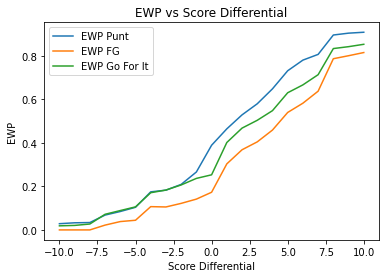

In [74]:
sweep_range = range(-10,11)
df_sweep = sweep_state(base_states[11], sweep_var='score_differential', sweep_values=sweep_range)
x = df_sweep['score_differential'].to_numpy().flatten()
y_punt = df_sweep['ewp_punt'].to_numpy().flatten()
y_fg = df_sweep['ewp_field_goal'].to_numpy().flatten()
y_go = df_sweep['ewp_go_for_it'].to_numpy().flatten()

plt.plot(x, y_punt, label='EWP Punt')
plt.plot(x, y_fg, label='EWP FG')
plt.plot(x, y_go, label='EWP Go For It')
plt.xlabel('Score Differential')
plt.ylabel('EWP')
plt.title('EWP vs Score Differential')
plt.legend()
plt.show()

Brier score: 0.16609
Reliability: 0.00002
Resolution: 0.08320
Uncertainty: 0.24999
Brier check (reliability - resolution + uncertainty): 0.16681


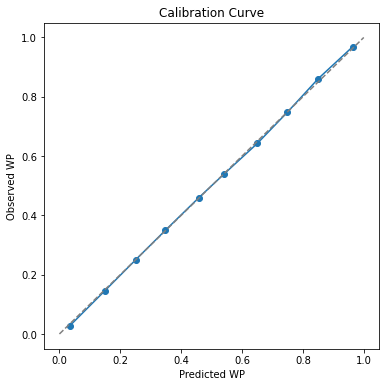

In [211]:
# ============================================================
# Step 1: Add predicted WP and actual win outcome
# ============================================================
plays_df = pbp.copy()
plays_df['wp_pred'] = predict_wp(plays_df)

# Compute final scores and win from offensive team perspective
final_scores = (
    pbp.groupby("game_id")
       .tail(1)[["game_id","home_team","away_team","home_score","away_score"]]
       .copy()
)
final_scores["home_win"] = (final_scores["home_score"] > final_scores["away_score"]).astype(int)

plays_df = plays_df.merge(final_scores[["game_id","home_win"]], on="game_id", how="left")
plays_df["win_actual"] = np.where(
    plays_df["posteam"] == plays_df["home_team"],
    plays_df["home_win"],
    1 - plays_df["home_win"]
)

# ============================================================
# Step 2: Compute calibration, Brier score, reliability/resolution
# ============================================================
# Bin predicted WP
bins = np.linspace(0, 1, 11)
wp_bin = pd.cut(plays_df['wp_pred'], bins, include_lowest=True)

# Aggregate by bin
cal_table = plays_df.groupby(wp_bin).agg(
    wp_pred_mean=('wp_pred', 'mean'),
    win_rate=('win_actual', 'mean'),
    count=('win_actual', 'count')
).reset_index()

# Brier score
brier = np.mean((plays_df['wp_pred'] - plays_df['win_actual'])**2)

# Reliability and resolution
N = len(plays_df)
reliability = np.sum(cal_table['count'] / N * (cal_table['wp_pred_mean'] - cal_table['win_rate'])**2)
resolution = np.sum(cal_table['count'] / N * (cal_table['win_rate'] - plays_df['win_actual'].mean())**2)
uncertainty = np.mean(plays_df['win_actual']) * (1 - np.mean(plays_df['win_actual']))
brier_check = reliability - resolution + uncertainty

# Print results
print(f"Brier score: {brier:.5f}")
print(f"Reliability: {reliability:.5f}")
print(f"Resolution: {resolution:.5f}")
print(f"Uncertainty: {uncertainty:.5f}")
print(f"Brier check (reliability - resolution + uncertainty): {brier_check:.5f}")

# Plot calibration
x = cal_table['wp_pred_mean'].values.ravel()  # ensures 1D
y = cal_table['win_rate'].values.ravel()     # ensures 1D

plt.figure(figsize=(6,6))
plt.plot(x, y, marker='o')
plt.plot([0,1], [0,1], '--', color='gray')
plt.xlabel('Predicted WP')
plt.ylabel('Observed WP')
plt.title('Calibration Curve')
plt.show()

In [212]:
cal_table

,wp_pred,wp_pred_mean,win_rate,count
0,"(-0.001, 0.1]",0.034430,0.027841,43820
1,"(0.1, 0.2]",0.150088,0.146561,29005
2,"(0.2, 0.3]",0.250926,0.250602,27817
3,"(0.3, 0.4]",0.348179,0.349717,37396
4,"(0.4, 0.5]",0.458098,0.459800,53619
5,"(0.5, 0.6]",0.541726,0.540196,54047
6,"(0.6, 0.7]",0.650734,0.643150,38512
7,"(0.7, 0.8]",0.748614,0.747488,32438
8,"(0.8, 0.9]",0.850541,0.861311,28755
9,"(0.9, 1.0]",0.963857,0.969080,44373


In [230]:
def predict_wp_array(X):
    """
    X: numpy array with columns ordered exactly as wp_features
    """
    X = X.copy()

    # indices
    idx_sd = wp_features.index("score_differential")
    idx_t  = wp_features.index("game_seconds_remaining")
    idx_str = wp_features.index("score_time_ratio")

    # compute score_time_ratio if needed
    X[:, idx_str] = np.abs(X[:, idx_sd]) / (X[:, idx_t] + 1)

    preds = wp_model.predict(X)
    return np.clip(preds, 0.0, 1.0)

In [237]:
N = len(plays_df)
delta_wp_fg = np.zeros(N, dtype=np.float32)

fg_mask = plays_df["kick_distance"].notna().values
wp_base = plays_df["wp_pred"].values

chunk_size = 25000

# Feature indices (resolved ONCE)
IDX = {c: i for i, c in enumerate(wp_features)}

# NumPy views (no copies)
fg_feat_array = plays_df[fg_features].to_numpy(dtype=np.float32, copy=False)
wp_feat_array = plays_df[wp_features].to_numpy(dtype=np.float32, copy=False)
yardline = plays_df["yardline_100"].values

for start in range(0, N, chunk_size):
    end = min(start + chunk_size, N)
    idx = slice(start, end)

    fg_idx = fg_mask[idx]

    # ----------------------------
    # FG make probability
    # ----------------------------
    p_make = np.zeros(end - start, dtype=np.float32)

    if fg_idx.any():
        p_make[fg_idx] = fg_final_model.predict_proba(
            fg_feat_array[idx][fg_idx]
        )[:, 1]

    # ========================================================
    # FG SUCCESS STATE (opponent ball at own 25)
    # ========================================================
    X_succ = wp_feat_array[idx].copy()

    X_succ[:, IDX["down"]] = 1
    X_succ[:, IDX["ydstogo"]] = 10
    X_succ[:, IDX["yardline_100"]] = 75
    X_succ[:, IDX["score_differential"]] += 3

    X_succ[:, IDX["half_seconds_remaining"]] = np.clip(
        X_succ[:, IDX["half_seconds_remaining"]] - 5, 0, None
    )
    X_succ[:, IDX["game_seconds_remaining"]] = np.clip(
        X_succ[:, IDX["game_seconds_remaining"]] - 5, 0, None
    )

    # flip possession via score differential
    X_succ[:, IDX["score_differential"]] *= -1

    wp_succ = 1 - predict_wp_array(X_succ)

    # ========================================================
    # FG FAILURE STATE (opponent takes over at spot)
    # ========================================================
    X_fail = wp_feat_array[idx].copy()

    X_fail[:, IDX["down"]] = 1
    X_fail[:, IDX["ydstogo"]] = 10
    X_fail[:, IDX["yardline_100"]] = 100 - (yardline[idx] + 7)

    X_fail[:, IDX["half_seconds_remaining"]] = np.clip(
        X_fail[:, IDX["half_seconds_remaining"]] - 5, 0, None
    )
    X_fail[:, IDX["game_seconds_remaining"]] = np.clip(
        X_fail[:, IDX["game_seconds_remaining"]] - 5, 0, None
    )

    X_fail[:, IDX["score_differential"]] *= -1

    wp_fail = 1 - predict_wp_array(X_fail)

    # ========================================================
    # Expected WP & ΔWP
    # ========================================================
    ewp = p_make * wp_succ + (1 - p_make) * wp_fail
    delta_wp_fg[idx] = ewp - wp_base[idx]

# Attach result
plays_df["delta_wp_fg"] = delta_wp_fg

In [240]:
go_mask = plays_df["down"] == 4

p_conv = np.zeros(len(plays_df))
p_conv[go_mask] = conv_model.predict_proba(
    plays_df.loc[go_mask, go_features]
)[:, 1]

X = plays_df[wp_features].to_numpy(dtype=np.float32)
IDX = {name: i for i, name in enumerate(wp_features)}

X_succ = X.copy()

# Yardline moves forward
X_succ[:, IDX["yardline_100"]] -= X[:, IDX["ydstogo"]]

# Reset downs
X_succ[:, IDX["down"]] = 1
X_succ[:, IDX["ydstogo"]] = 10

# Clock
X_succ[:, IDX["half_seconds_remaining"]] = np.maximum(
    X_succ[:, IDX["half_seconds_remaining"]] - 5, 0
)
X_succ[:, IDX["game_seconds_remaining"]] = np.maximum(
    X_succ[:, IDX["game_seconds_remaining"]] - 5, 0
)

wp_succ = predict_wp_array(X_succ)

X_fail = X.copy()

# Turnover on downs: opponent gets ball
X_fail[:, IDX["yardline_100"]] = 100 - X[:, IDX["yardline_100"]]

# Reset downs
X_fail[:, IDX["down"]] = 1
X_fail[:, IDX["ydstogo"]] = 10

# Flip score perspective
X_fail[:, IDX["score_differential"]] *= -1

# Clock
X_fail[:, IDX["half_seconds_remaining"]] = np.maximum(
    X_fail[:, IDX["half_seconds_remaining"]] - 5, 0
)
X_fail[:, IDX["game_seconds_remaining"]] = np.maximum(
    X_fail[:, IDX["game_seconds_remaining"]] - 5, 0
)

wp_fail = 1 - predict_wp_array(X_fail)

ewp_go_all = p_conv * wp_succ + (1 - p_conv) * wp_fail
delta_wp_go_all = ewp_go_all - plays_df["wp_pred"].values

plays_df["delta_wp_go"] = delta_wp_go_all

In [241]:
plays_df["delta_wp_go"].describe()

count    389782.000000
mean         -0.087912
std           0.077862
min          -0.615440
25%          -0.136557
50%          -0.091275
75%          -0.037456
max           0.476796
Name: delta_wp_go, dtype: float64

In [242]:
pbp.shape

(389782, 403)